In [1]:
import keras
batch_size = 4
input_path = "D:\Tesi Dataset\Z_Test_Dataset\\256_resized_Face"
output_path= "D:\Tesi Dataset\Z_Test_Dataset\\256_resized_UV"

training_size = 0.7
random_seed=13
steps_per_epoch=26
epochs=5

## Data Preprocessing


In [2]:
import os
input_img_paths = sorted(
    [
        os.path.join(input_path, fname)
        for fname in os.listdir(input_path)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(output_path, fname)
        for fname in os.listdir(output_path)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

if len(input_img_paths) != len(target_img_paths):
    raise ValueError("The number of images doesn't match.")
print("Number of samples:", len(input_img_paths))

Number of samples: 150


In [3]:
from tensorflow import data as tf_data
from tensorflow import io as tf_io
from tensorflow import image as tf_image

def get_dataset(
    batch_size,
    input_img_paths,
    target_img_paths,
    max_dataset_len=None,
):
    """Returns a TF Dataset."""
    def load_img(input_img_path, target_img_path):
        input_img = tf_io.read_file(input_img_path)
        input_img = tf_io.decode_png(input_img, channels=3)
        input_img = tf_image.convert_image_dtype(input_img, "float32")

        target_img = tf_io.read_file(target_img_path)
        target_img = tf_io.decode_png(target_img, channels=3)
        target_img = tf_image.convert_image_dtype(target_img, "float32")

        return input_img, target_img

    if max_dataset_len:
        input_img_paths = input_img_paths[:max_dataset_len]
        target_img_paths = target_img_paths[:max_dataset_len]
    dataset = tf_data.Dataset.from_tensor_slices((input_img_paths, target_img_paths))
    dataset = dataset.map(load_img, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.batch(batch_size)

In [4]:
import random

# Split our img paths into a training and a validation set
random.Random(random_seed).shuffle(input_img_paths)
random.Random(random_seed).shuffle(target_img_paths)

# K=int(len(input_img_paths)*training_size/batch_size)*batch_size
# T=int(len(input_img_paths)*training_size/batch_size)*batch_size
K=int(len(input_img_paths)*training_size/batch_size)*batch_size
T=int(len(input_img_paths)*(training_size+(1-training_size)/2)/batch_size)*batch_size

train_input_img_paths = input_img_paths[:K]
train_target_img_paths = target_img_paths[:K]

val_input_img_paths = input_img_paths[K:T]
val_target_img_paths = target_img_paths[K:T]

test_input_img_paths = input_img_paths[T:]
test_target_img_paths = target_img_paths[T:]

train_dataset = get_dataset(
    batch_size,
    train_input_img_paths,
    train_target_img_paths,
)
valid_dataset = get_dataset(
    batch_size, val_input_img_paths, val_target_img_paths
)
test_dataset = get_dataset(
    1, test_input_img_paths, test_target_img_paths
)

print("Size Train Set: ",len(train_dataset),"\nSize Valid Set: ",len(valid_dataset),"\nSize Test Set: ",len(test_dataset))

# train_dataset=train_dataset.repeat()
# valid_dataset=valid_dataset.repeat()
# test_dataset=test_dataset.repeat()

Size Train Set:  26 
Size Valid Set:  5 
Size Test Set:  26


## Model


In [20]:
from keras.layers import  Conv2D, Conv2DTranspose, SpatialDropout2D
model = keras.Sequential()

def encoder_block(model, num_filters, depth=3):
    model.add(Conv2D(num_filters, (3, 3),strides=2, activation='relu', padding='same',name=f"{num_filters}_Conv_1"))
    model.add(SpatialDropout2D(0.5))
    
    for i in range(depth-1):
        model.add(Conv2D(num_filters, (3, 3), activation='relu', padding='same',name=f"{num_filters}_Conv_{i+2}"))
        model.add(SpatialDropout2D(0.5))
    
    return model

def decoder_block(model, num_filters, depth=3):
    model.add(Conv2DTranspose(num_filters, (3, 3),strides=2, activation='relu', padding='same',name=f"{num_filters}_T-Conv_1"))
    model.add(SpatialDropout2D(0.5))

    for i in range(depth-1):
        model.add(Conv2DTranspose(num_filters, (3, 3), activation='relu', padding='same',name=f"{num_filters}_T-Conv_{i+2}"))
        model.add(SpatialDropout2D(0.5))

    return model

def autoencoder():
    # Encoder
    model.add(Conv2D(3, (3, 3), activation='relu', padding='same', input_shape=(256, 256,3),name="input"))
    model.add(SpatialDropout2D(0.5))
    
    encoder_block(model, 32,depth=3)
    encoder_block(model, 64,depth=5)
    encoder_block(model, 128,depth=7)
    encoder_block(model, 256,depth=9)

    # Decoder
    decoder_block(model, 256,depth=9)
    decoder_block(model, 128,depth=7)
    decoder_block(model, 64,depth=5)
    decoder_block(model, 32,depth=3)

    model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same',name="output"))
    model.add(SpatialDropout2D(0.5))

    # Compile the model
    model.compile(optimizer='adamax', loss='binary_crossentropy',
                  metrics=[keras.metrics.MeanAbsoluteError()])
    
    return model

model = autoencoder()

# Summarize the model
model.summary()
keras.utils.plot_model(model, to_file="autoencoder.png", show_shapes=True)

c:\Users\Francesco\miniconda3\envs\texture-env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (Conv2D)                  │ (None, 256, 256, 3)    │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d               │ (None, 256, 256, 3)    │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 32_Conv_1 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_1             │ (None, 128, 128, 32)   │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 32_Conv_2 (Conv2D)              │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_2             │ (None, 128, 128, 32)   │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 32_Conv_3 (Conv2D)              │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_3             │ (None, 128, 128, 32)   │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 64_Conv_1 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_4             │ (None, 64, 64, 64)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 64_Conv_2 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_5             │ (None, 64, 64, 64)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 64_Conv_3 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_6             │ (None, 64, 64, 64)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 64_Conv_4 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_7             │ (None, 64, 64, 64)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 64_Conv_5 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_8             │ (None, 64, 64, 64)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 128_Conv_1 (Conv2D)             │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_9             │ (None, 32, 32, 128)    │             0 │
│ (SpatialDropout2D)              │                        │             

 Total params: 12,911,447 (49.25 MB)

 Trainable params: 12,911,447 (49.25 MB)

 Non-trainable params: 0 (0.00 B)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


## Training


In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=5),
    # keras.callbacks.ModelCheckpoint("Interim_Model.keras", save_best_only=True),
    keras.callbacks.CSVLogger("checkpoint/Logger"),
]

model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    verbose=1,
    # steps_per_epoch=steps_per_epoch,
    # validation_steps=5,
    callbacks=callbacks,
)

Epoch 1/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - loss: 0.6874 - mean_absolute_error: 0.1927 - val_loss: 0.6675 - val_mean_absolute_error: 0.1640
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - loss: 0.6725 - mean_absolute_error: 0.1786 - val_loss: 0.6593 - val_mean_absolute_error: 0.1575
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - loss: 0.6673 - mean_absolute_error: 0.1747 - val_loss: 0.6399 - val_mean_absolute_error: 0.1420
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - loss: 0.6391 - mean_absolute_error: 0.1431 - val_loss: 0.6213 - val_mean_absolute_error: 0.1205
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - loss: 0.6194 - mean_absolute_error: 0.1149 - val_loss: 0.6139 - val_mean_absolute_error: 0.1060


## Testing


In [ ]:
model.evaluate(test_dataset)

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.6135 - mean_absolute_error: 0.1138


[0.6138368844985962, 0.10601039230823517]

#### Predictions Visualization


In [ ]:
predictions = model.predict(test_dataset)

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step


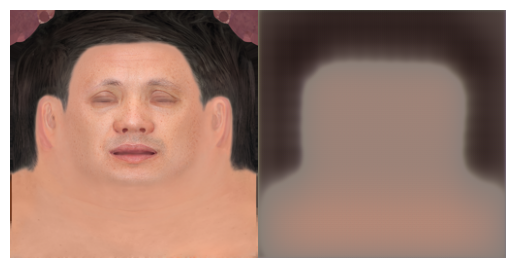

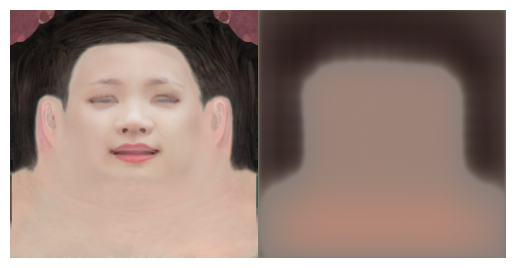

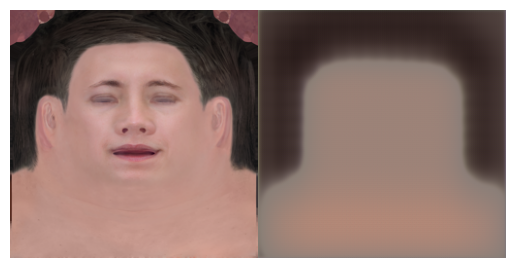

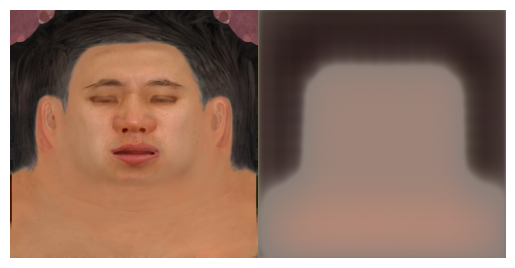

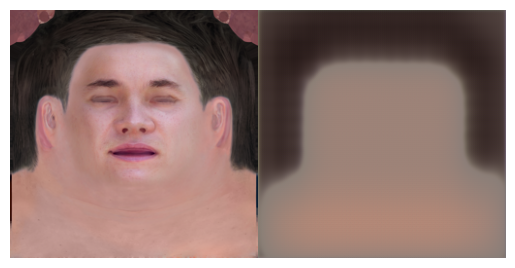

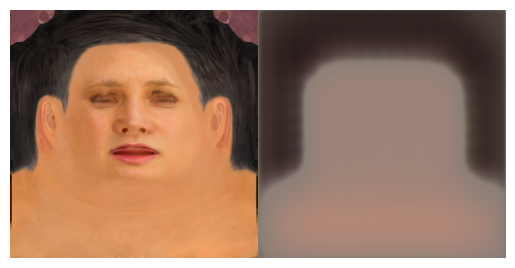

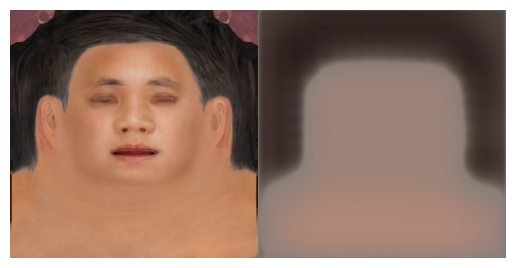

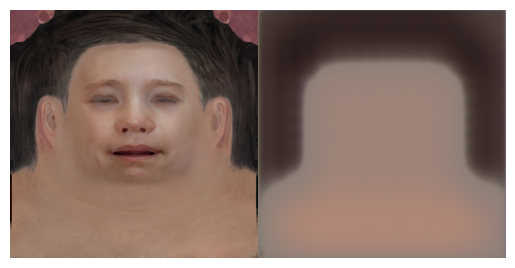

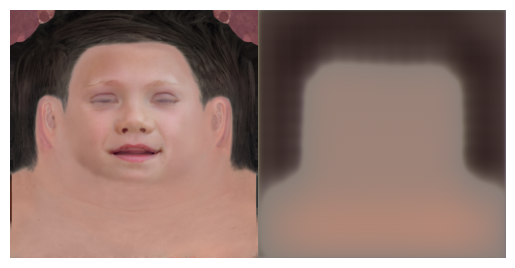

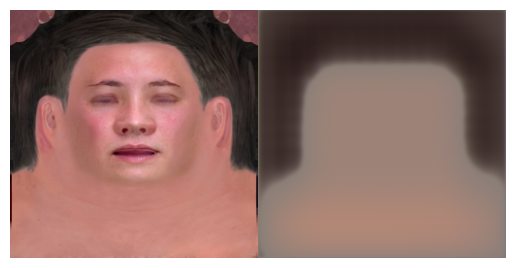

In [ ]:
from src.visualization.image_plot import image_plot
from itertools import islice
import numpy as np  

for j,k in islice(zip(test_dataset, predictions), 10):
    image_plot(np.concatenate((j[1].numpy()[0], k), axis=1))

## Model Save


In [ ]:
model.save("Model.keras")